In [96]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout
from sklearn.cluster import KMeans, MeanShift
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
import IPython
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [97]:
import opendatasets as od

# token 362de83c625279a01f8399c58a63abe8
od.download("https://www.kaggle.com/datasets/arshid/iris-flower-dataset")

Skipping, found downloaded files in "./iris-flower-dataset" (use force=True to force download)


In [98]:
df = pd.read_csv('iris-flower-dataset/IRIS.csv')
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
139,6.9,3.1,5.4,2.1,Iris-virginica
115,6.4,3.2,5.3,2.3,Iris-virginica
118,7.7,2.6,6.9,2.3,Iris-virginica
144,6.7,3.3,5.7,2.5,Iris-virginica
2,4.7,3.2,1.3,0.2,Iris-setosa


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [100]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [101]:
X = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = df['species']

In [102]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [103]:
X.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [104]:
y.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [105]:
colors = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}

In [106]:
embs = umap.UMAP().fit_transform(X)

In [107]:
kmeans = KMeans(n_clusters=3).fit(X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [108]:
clustering = MeanShift(bandwidth=0.3).fit(X)

Text(0.5, 1.0, 'MeanShift')

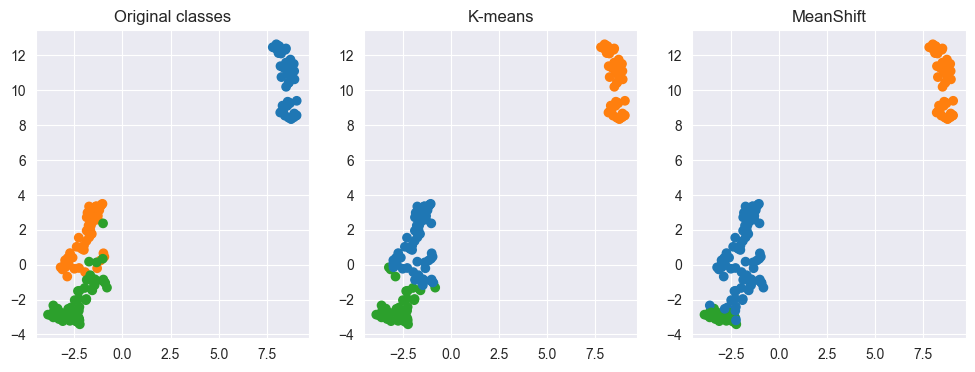

<Figure size 300x600 with 0 Axes>

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plt.figure(figsize=(3, 6))
ax1.scatter(embs[:, 0], embs[:, 1], color=[sns.color_palette()[colors[name]] for name in y])
ax1.set_title('Original classes')
ax2.scatter(embs[:,0], embs[:,1], color=[sns.color_palette()[label] for label in kmeans.labels_])
ax2.set_title('K-means')
ax3.scatter(embs[:,0], embs[:,1], color=[sns.color_palette()[label] for label in clustering.labels_])
ax3.set_title('MeanShift')


Внешняя мера

In [126]:
def eval_metrics(labels_pred, labels, embs):
    return metrics.adjusted_rand_score(labels, labels_pred), metrics.davies_bouldin_score(embs, labels_pred)

In [127]:
# k-means
eval_metrics(kmeans.labels_, y.map(colors), embs)

(0.13934243409325206, 0.8962081352271102)

In [128]:
# MeanShift
eval_metrics(clustering.labels_, y.map(colors), embs)

(0.5934865709792337, 0.5064057515562371)

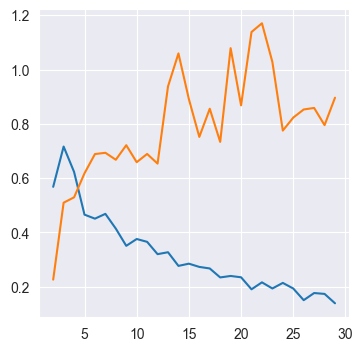

In [134]:
axis_x = []
axis_y = []

for i in range(2, 30) :
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10).fit(X)
    axis_x += [i]
    axis_y += [eval_metrics(kmeans.labels_, y.map(colors), embs)]
plt.plot(axis_x, axis_y)
plt.show()

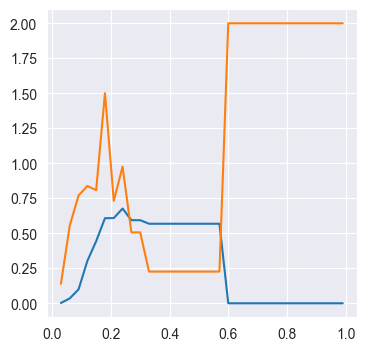

In [137]:
axis_x = []
axis_y = []

for i in np.arange(0.03, 1, 0.03) :
    axis_x += [i]
    clusters = MeanShift(bandwidth=i).fit(X)
    if max(clusters.labels_) == 0 or max(clusters.labels_) == 150 :
        axis_y += [(metrics.adjusted_rand_score(y.map(colors), clusters.labels_), 2)]
        continue
    axis_y += [eval_metrics(clusters.labels_, y.map(colors), embs)]
plt.plot(axis_x, axis_y)
plt.show()